In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
#import ml_metrics as metrics
import pmdarima as pm
import math
from statsmodels import *
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

In [18]:
data = pd.read_csv('AirPassengers.csv', delimiter=",")
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)
data

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


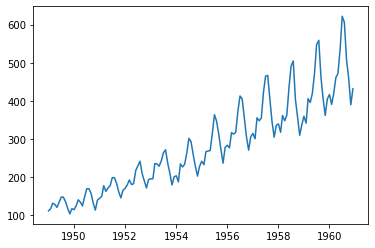

In [19]:
plt.plot(data["Month"], data["#Passengers"])
plt.show(block=False)

In [20]:
#Подготовка данных к чтению
otherData = data
otherData['Month'] = pd.to_datetime(otherData['Month'], infer_datetime_format=True)
otherData = otherData.set_index('Month', inplace=False)
rolmean = otherData.rolling(window=12).mean()
rolstd = otherData.rolling(window=12).std()

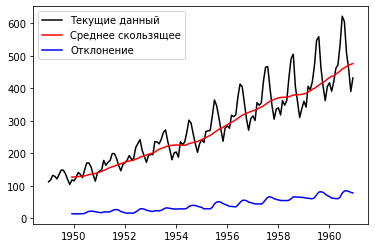

In [21]:
#Отрисовка данных
actual = plt.plot(otherData, color='black', label='Текущие данный')
mean_6 = plt.plot(rolmean, color='red', label='Среднее скользящее')
std_6 = plt.plot(rolstd, color='blue', label='Отклонение')
plt.legend(loc='best')
plt.show(block=False)

In [22]:
# Логарифмирование временного ряда и вычитание из него скользящего среднего логарифмированного ряда
data_log = np.log(otherData).dropna()
MAvg = data_log.rolling(window=3).mean()
MStd = data_log.rolling(window=3).std()
data_log_diff = data_log - MAvg
data_log_diff = data_log_diff.dropna()

In [23]:
# Функция для определения станционарности по тесту ADF
from statsmodels.tsa.stattools import adfuller


def isStationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    plt.figure(figsize=(20, 10))
    actual = plt.plot(timeseries, color='black', label='Текущие данные')
    mean_6 = plt.plot(rolmean, color='red', label='Среднее скользящее')
    std_6 = plt.plot(rolstd, color='blue', label='Отклонение')
    plt.legend(loc='best')
    plt.show(block=False)

    print('Dickey-Fuller Test: ')

    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'No. of Obs'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(dfoutput)

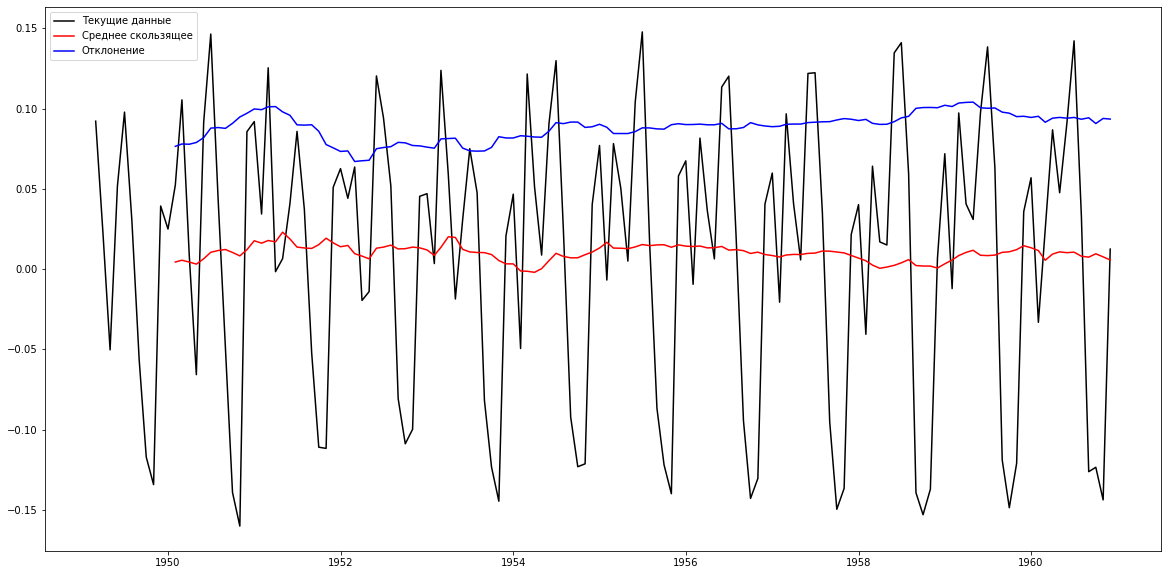

Dickey-Fuller Test: 
Test Statistic           -3.040034
p-value                   0.031321
Lags Used                11.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [24]:
# Подтверждение станционарности прологарифмированного ряда
isStationarity(data_log_diff)

Text(0.5, 1.0, 'Частичная автокорреляционная функция')

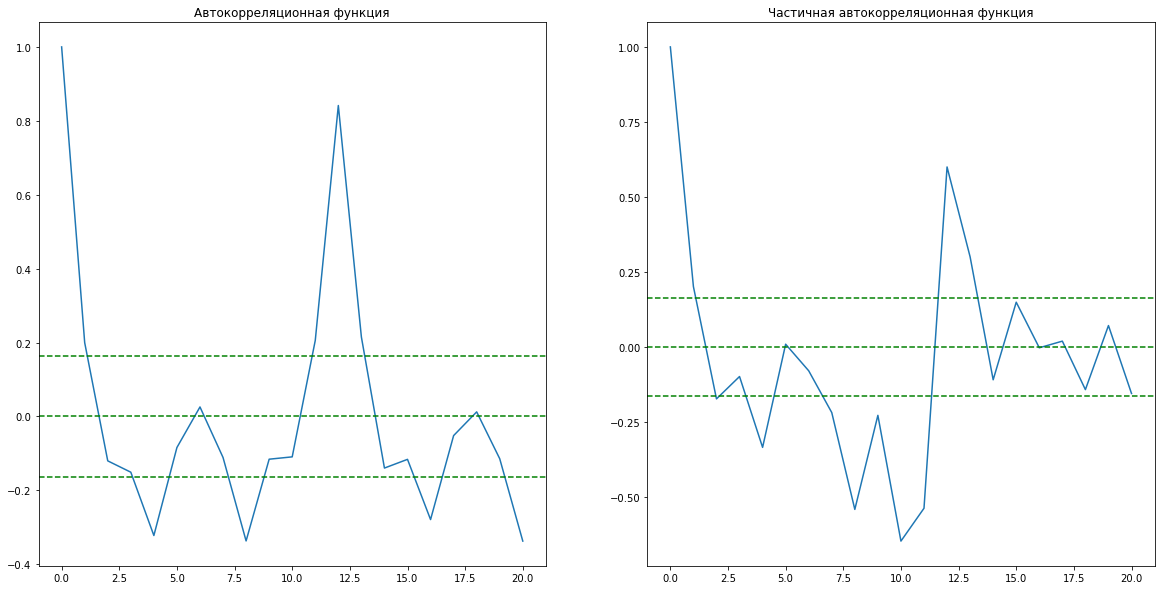

In [25]:
# Построение графика ACF и PACF для нахождения значений q и p
from statsmodels.tsa.stattools import acf, pacf

data_shift = data_log - data_log.shift()
data_shift = data_shift.dropna()

lag_acf = acf(data_shift, nlags=20)
lag_pacf = pacf(data_shift, nlags=20, method='ols')

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='green')
plt.axhline(y=-1.96 / np.sqrt(len(data_shift)), linestyle='--', color='green')
plt.axhline(y=1.96 / np.sqrt(len(data_shift)), linestyle='--', color='green')
plt.title('Автокорреляционная функция')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='green')
plt.axhline(y=-1.96 / np.sqrt(len(data_shift)), linestyle='--', color='green')
plt.axhline(y=1.96 / np.sqrt(len(data_shift)), linestyle='--', color='green')
plt.title('Частичная автокорреляционная функция')

#Мы получили q и p оба 2 из графика


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


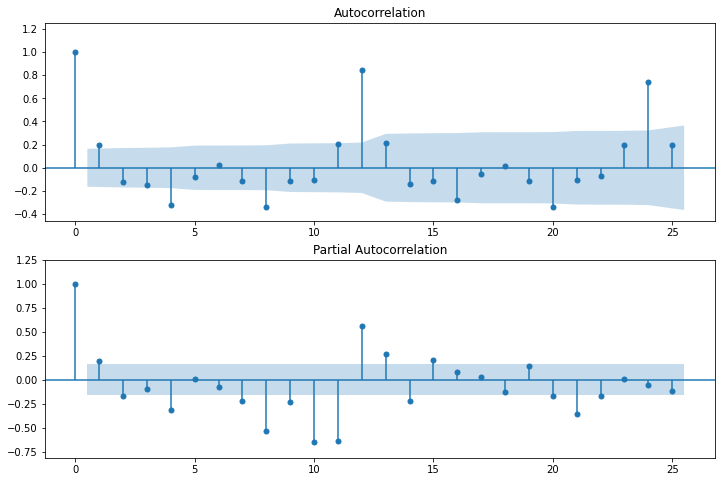

In [26]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data_shift.values.squeeze(), lags=25, ax=ax1, auto_ylims="true")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_shift, lags=25, ax=ax2, auto_ylims="true")

In [27]:
train_data = otherData['#Passengers'][:int(len(otherData) * 0.8)]
test_data = otherData['#Passengers'][int(len(otherData) * 0.8):]

In [28]:
ARIMA_model = pm.auto_arima(train_data, m=12)
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -375.750
Date:                            Wed, 30 Nov 2022   AIC                            755.499
Time:                                    13:25:21   BIC                            760.749
Sample:                                01-01-1949   HQIC                           757.625
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2048      0.090     -2.271      0.023      -0.382      -0.028
sigma2        92.6974     13.326      6.956      0.000      66.579     118.816
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.87   Prob(JB):                         0.30
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization faile

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                ARIMA(12, 1, 1)   Log Likelihood                -424.153
Date:                Wed, 30 Nov 2022   AIC                            876.306
Time:                        13:25:27   BIC                            914.613
Sample:                    01-01-1949   HQIC                           891.853
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0904      0.088      1.023      0.307      -0.083       0.264
ar.L2         -0.0931      0.067     -1.382      0.167      -0.225       0.039
ar.L3          0.0494      0.057      0.865      0.387      -0.063       0.161
ar.L4         -0.0914      0.059     -1.540      0.124      -0.208       0.025
ar.L5          0.0613      0.062      0.983      0.326      -0.061       0.183
ar.L6         -0.0798      0.057     -1.411      0.158      -0.191       0.031
ar.L7          0.0122      0.068      0.179      0.858      -0.121       0.145
ar.L8         -0.1151      0.061     -1.891      0.059      -0.234       0.004
ar.L9          0.0412      0.068      0.602      0.547      -0.093       0.175
ar.L10        -0.1205      0.059     -2.057      0.040      -0.235      -0.006
ar.L11         0.0880      0.067      1.317      0.188      -0.043       0.219
ar.L12         0.8161      0.064     12.728      0.000       0.690       0.942
ma.L1         -0.2507      0.142     -1.760      0.078      -0.530       0.028
sigma2        82.5742     12.924      6.389      0.000      57.244     107.905
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 3.00
Prob(Q):                              0.72   Prob(JB):                         0.22
Heteroskedasticity (H):               1.86   Skew:                             0.40
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

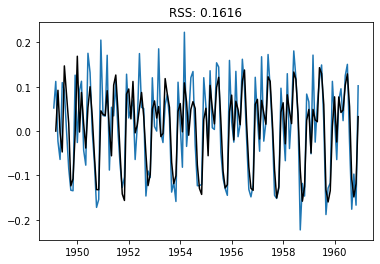

In [29]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data_log_diff, order=(12, 1, 1))
results = model.fit()
plt.plot(data_shift)
plt.plot(results.fittedvalues, color='black')
plt.title('RSS: %.4f' % sum((results.fittedvalues - data_log_diff['#Passengers']) ** 2))

model = ARIMA(train_data, order=(12, 1, 1))
model_fit = model.fit()
model_fit.summary()


In [30]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
#predictions_ARIMA_diff.drop(index=predictions_ARIMA_diff.index [0], axis= 0 , inplace= True )
predictions_ARIMA_diff.head()

Month
1949-03-01    0.00000
1949-04-01    0.09214
1949-05-01   -0.00364
1949-06-01   -0.04715
1949-07-01    0.14716
dtype: float64

In [31]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-03-01    0.000000
1949-04-01    0.092140
1949-05-01    0.088500
1949-06-01    0.041350
1949-07-01    0.188509
dtype: float64

In [32]:
predictions_ARIMA_log = pd.Series(data_log['#Passengers'].iloc[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.810639
1949-05-01    4.806999
dtype: float64

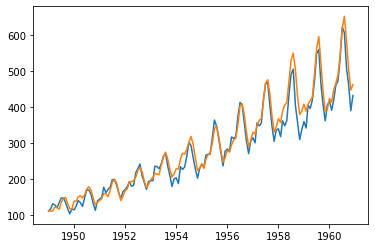

In [33]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(otherData)
plt.plot(predictions_ARIMA)

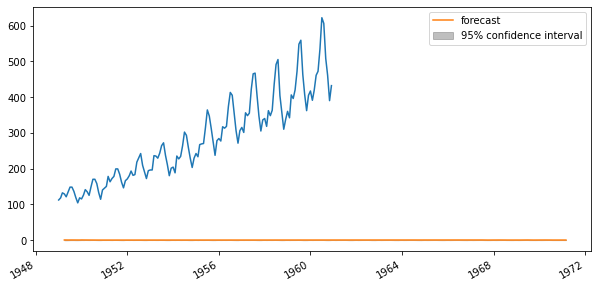

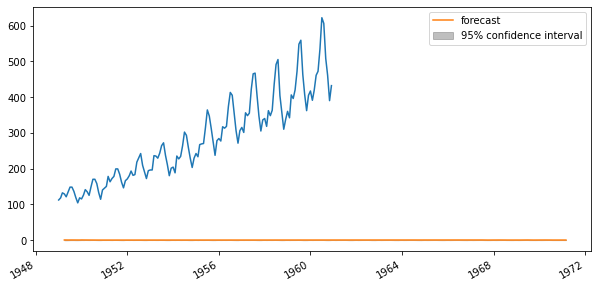

In [34]:
from statsmodels.graphics.tsaplots import plot_predict

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
results.summary()
plt.plot(otherData)
plot_predict(results, 1, 264, ax=axs)
#x=results.forecast(steps=120)

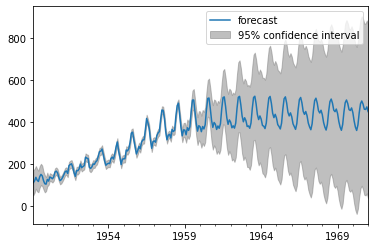

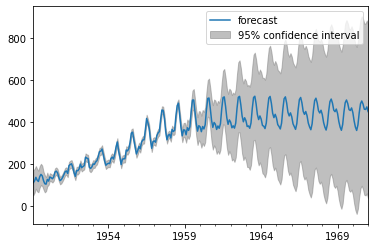

In [35]:
#plt.plot(otherData)
plot_predict(model_fit, 1, 264)
